In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [2]:
import gc

def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import IPython.display as ipd
import imageio
import copy
from tensorboardX import SummaryWriter
import pickle 

writeTensorboard = True
if(writeTensorboard):
    writer = SummaryWriter('tensorboard/run1/')

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")

model_dir = "./models/"
import models
from plot_utils import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from model_utils import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty
from helpers import trueAfterN, logsumexp
from sws_utils import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune

#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)
#train_dataset.train_labels = train_dataset.train_labels.float()
#test_dataset.test_labels = test_dataset.test_labels.float()

model_name = "SWSModel"

In [4]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_data_full = Variable(train_dataset.train_data.float()/255.0).cuda()
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
train_labels_full = Variable(train_dataset.train_labels).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()

#arguments
#model_name = 'LeNet_300_100'
training_epochs=100
#retraining_epochs=50
#temp_list = [1, 5, 10, 15, 20, 25, 30]

### 2. Re-train Model with GMM Constraints

In [45]:
#Load Targets
model_file = 'mnist_{}_{}'.format(model_name, training_epochs)
model = torch.load("{}{}.m".format(model_dir, model_file)).cuda()
model_acc = torch.load("{}{}.m".format(model_dir, model_file)).cuda()
#targets = model.kd_layer_targets(train_data_full)
#for layer in targets:
#    torch.save(targets[layer], "{}{}/{}.m".format(model_dir, model_file, layer))

In [6]:
target_layers = list(set([x.split(".")[0] for x in model.state_dict().keys()]))
kd_targets = {}
for layer in target_layers:
    kd_targets[layer+".act"] = torch.load("{}{}/{}.act.m".format(model_dir, model_file, layer))
    kd_targets[layer+".out"] = torch.load("{}{}/{}.out.m".format(model_dir, model_file, layer))

In [7]:
l1_dataset = torch.utils.data.TensorDataset(train_data_full, kd_targets['conv1.out'].data)#.data turns variable -> tensor
l1_loader = torch.utils.data.DataLoader(dataset=l1_dataset, batch_size=batch_size, shuffle=True)

l2_dataset = torch.utils.data.TensorDataset(kd_targets['conv1.act'].data, kd_targets['conv2.out'].data)#.data turns variable -> tensor
l2_loader = torch.utils.data.DataLoader(dataset=l2_dataset, batch_size=batch_size, shuffle=True)

l3_dataset = torch.utils.data.TensorDataset(kd_targets['conv2.act'].data, kd_targets['fc1.out'].data)#.data turns variable -> tensor
l3_loader = torch.utils.data.DataLoader(dataset=l3_dataset, batch_size=batch_size, shuffle=True)

l4_dataset = torch.utils.data.TensorDataset(kd_targets['fc1.act'].data, kd_targets['fc2.out'].data)#.data turns variable -> tensor
l4_loader = torch.utils.data.DataLoader(dataset=l4_dataset, batch_size=batch_size, shuffle=True)                                            

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 25.0
Model Name: SWSModelFC2 Epochs: 100
10x500 + 10
Layer Loss: 3327.047
Layer Loss: 5.556
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -101530.500
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


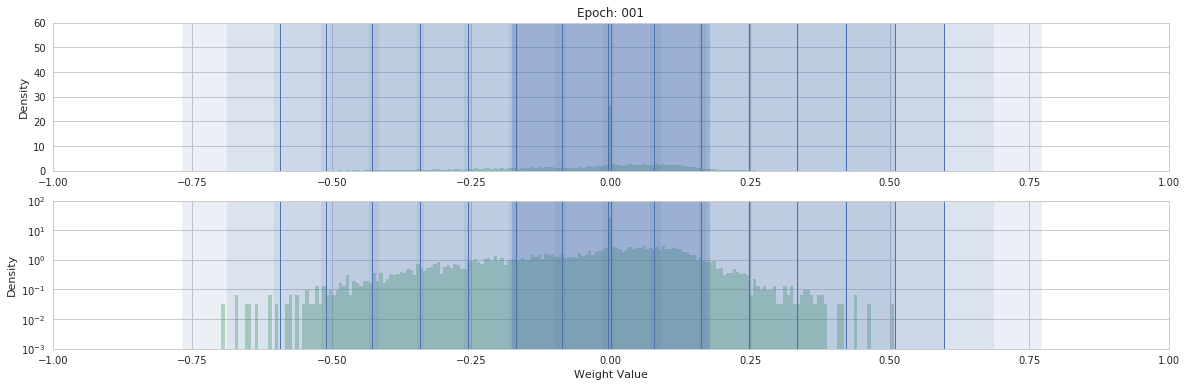

Epoch: 1. Loss: 0.00
Layer Loss: 2609.635
Layer Loss: 3.045
0-neglogprop Loss: -17203.551
Remaining-neglogprop Loss: -125180.617
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


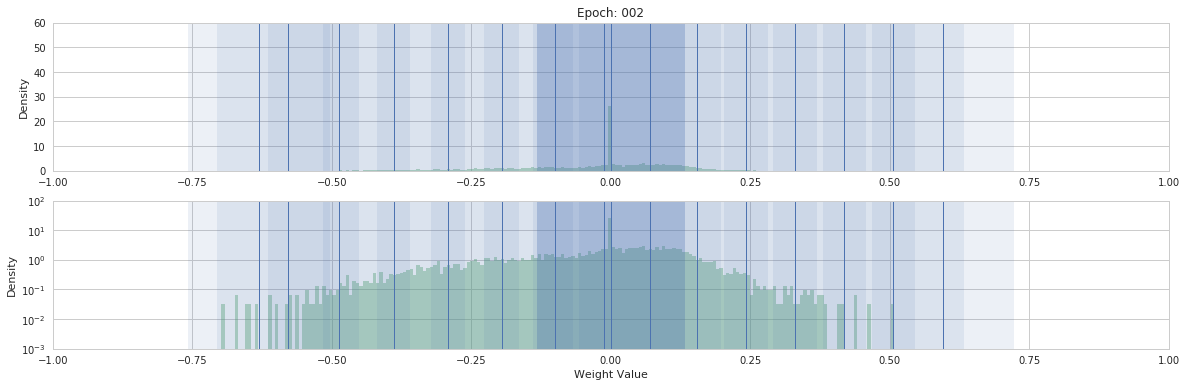

Epoch: 2. Loss: 0.00
Layer Loss: 2727.618
Layer Loss: 1.531
0-neglogprop Loss: -20100.838
Remaining-neglogprop Loss: -145309.438
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


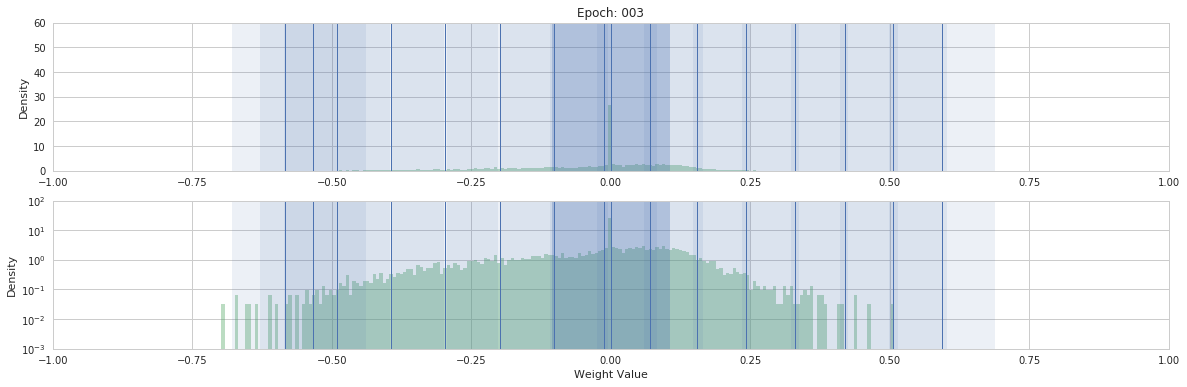

Epoch: 3. Loss: 0.00
Layer Loss: 3464.945
Layer Loss: 1.025
0-neglogprop Loss: -22292.387
Remaining-neglogprop Loss: -159648.312
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


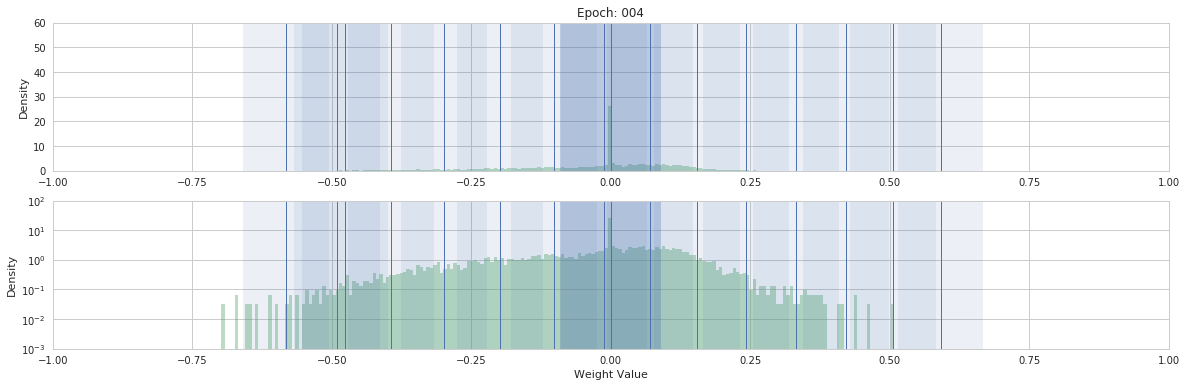

Epoch: 4. Loss: 0.01
Layer Loss: 4351.590
Layer Loss: 1.115
0-neglogprop Loss: -23786.107
Remaining-neglogprop Loss: -166951.047
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


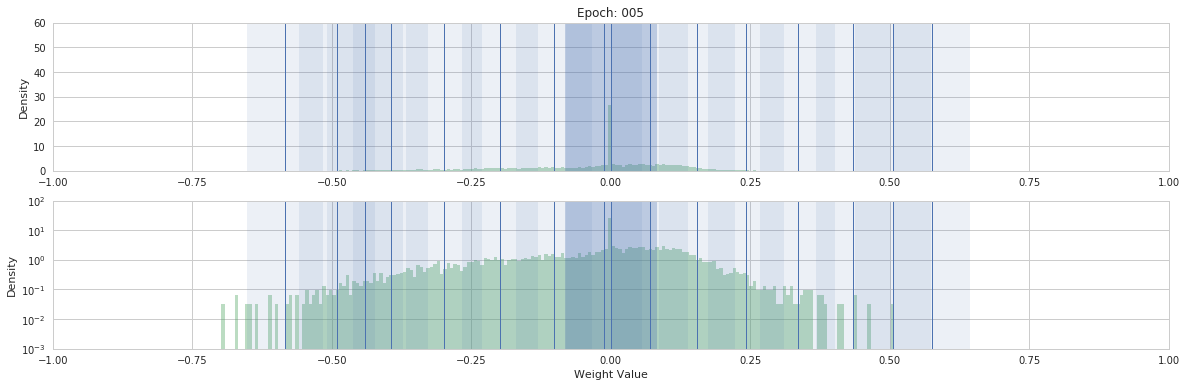

Epoch: 5. Loss: 0.00
Layer Loss: 5049.844
Layer Loss: 1.274
0-neglogprop Loss: -24679.957
Remaining-neglogprop Loss: -169119.859
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


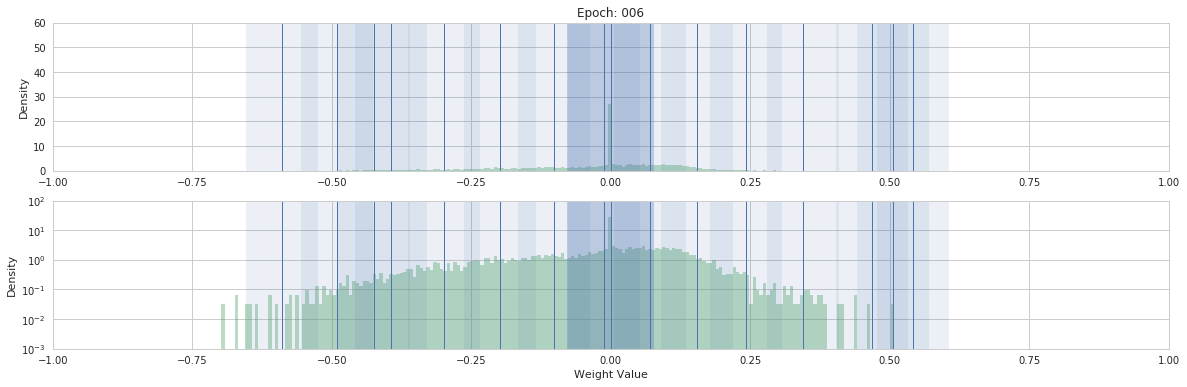

Epoch: 6. Loss: 0.00
Layer Loss: 5479.525
Layer Loss: 1.270
0-neglogprop Loss: -25156.578
Remaining-neglogprop Loss: -169445.266
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


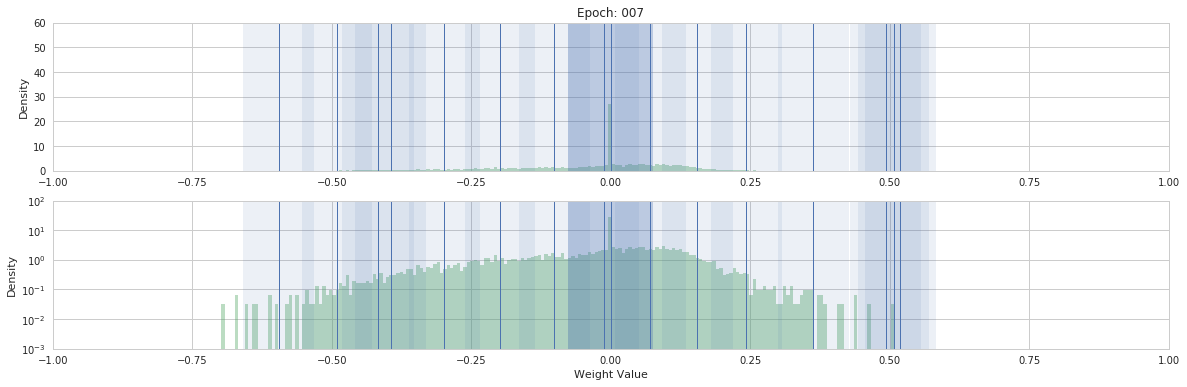

Epoch: 7. Loss: 0.00
Layer Loss: 5689.862
Layer Loss: 1.109
0-neglogprop Loss: -25376.346
Remaining-neglogprop Loss: -169470.281
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


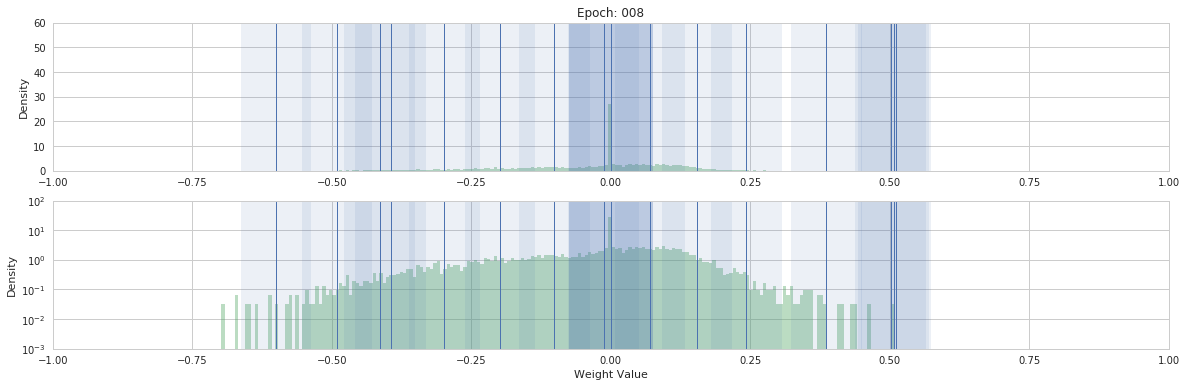

Epoch: 8. Loss: 0.00
Layer Loss: 5771.709
Layer Loss: 0.877
0-neglogprop Loss: -25461.424
Remaining-neglogprop Loss: -169471.391
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


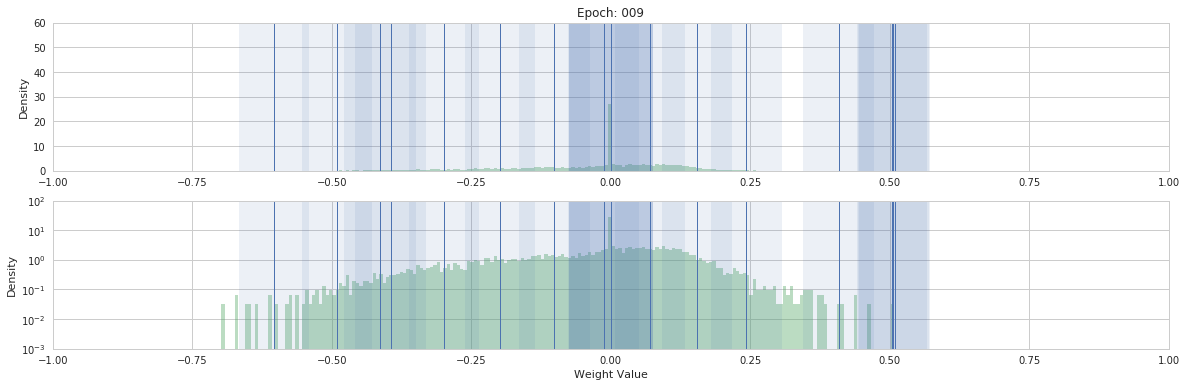

Epoch: 9. Loss: 0.00
Layer Loss: 5799.996
Layer Loss: 0.638
0-neglogprop Loss: -25489.469
Remaining-neglogprop Loss: -169471.391
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


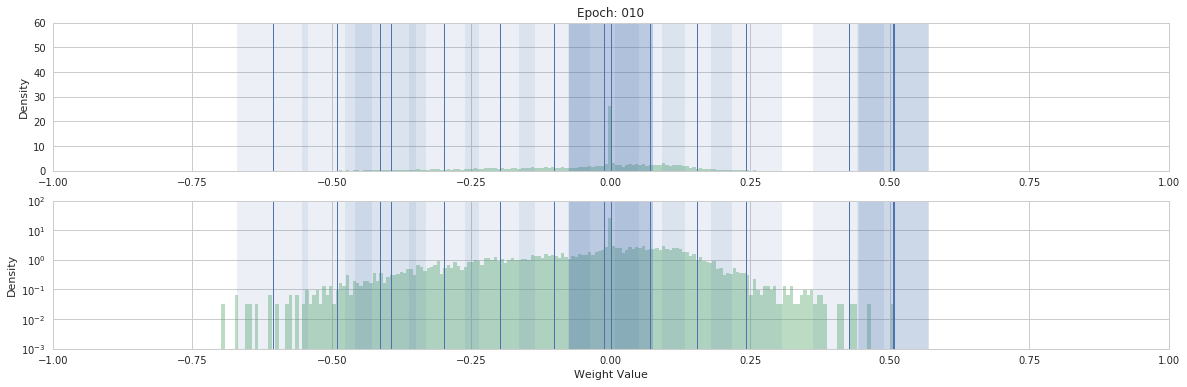

Epoch: 10. Loss: 0.01
Layer Loss: 5808.982
Layer Loss: 0.400
0-neglogprop Loss: -25497.662
Remaining-neglogprop Loss: -169471.375
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


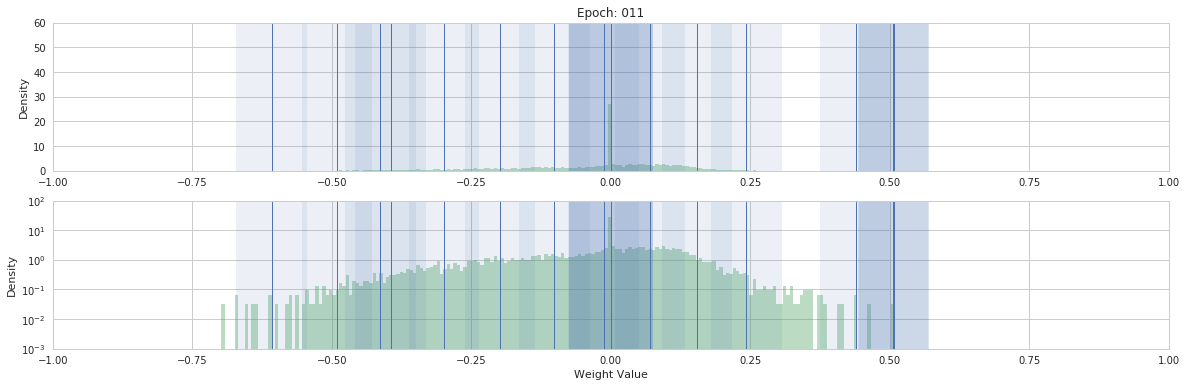

Epoch: 11. Loss: 0.00
Layer Loss: 5810.815
Layer Loss: 0.204
0-neglogprop Loss: -25500.166
Remaining-neglogprop Loss: -169471.375
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


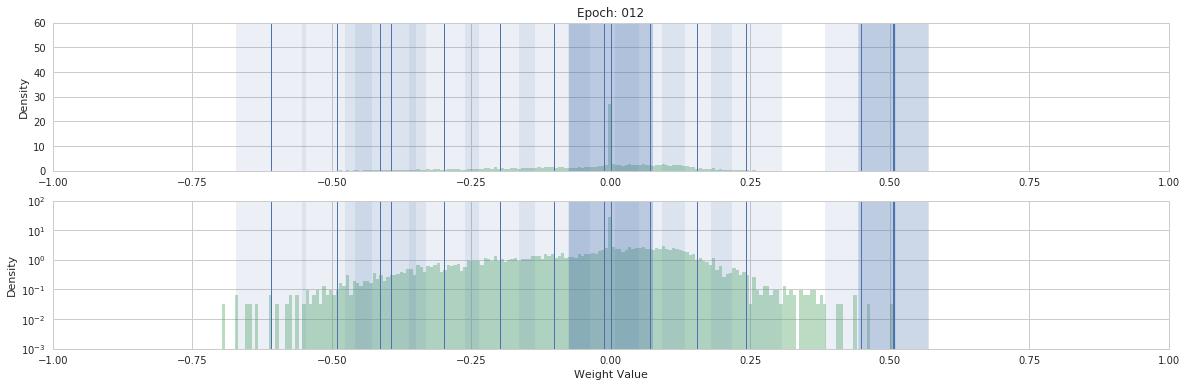

Epoch: 12. Loss: 0.01
Layer Loss: 5809.213
Layer Loss: 0.012
0-neglogprop Loss: -25500.699
Remaining-neglogprop Loss: -169471.375
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


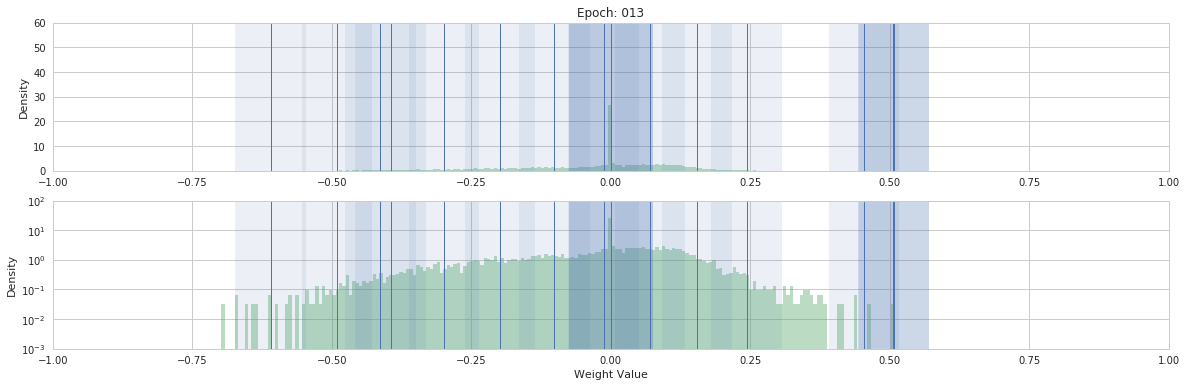

Epoch: 13. Loss: 0.00
Layer Loss: 5810.872
Layer Loss: -0.139
0-neglogprop Loss: -25501.391
Remaining-neglogprop Loss: -169471.375
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


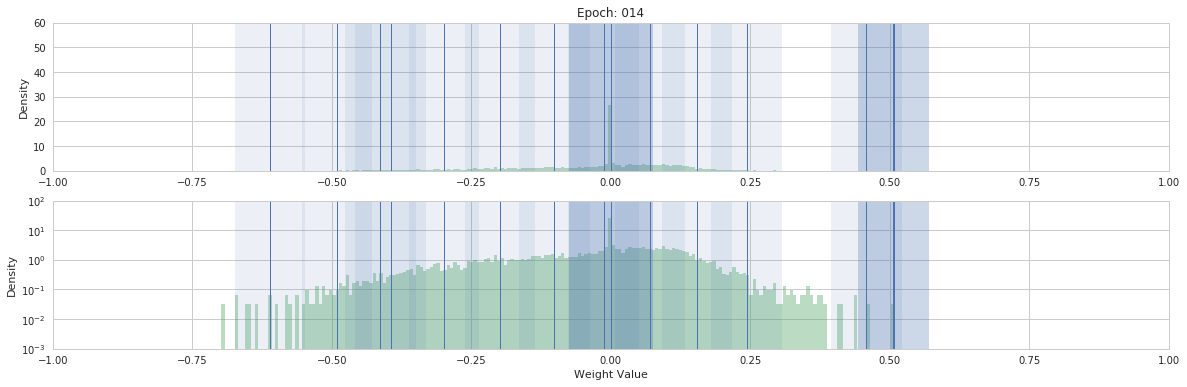

Epoch: 14. Loss: 0.00
Layer Loss: 5810.986
Layer Loss: -0.277
0-neglogprop Loss: -25501.447
Remaining-neglogprop Loss: -169471.375
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


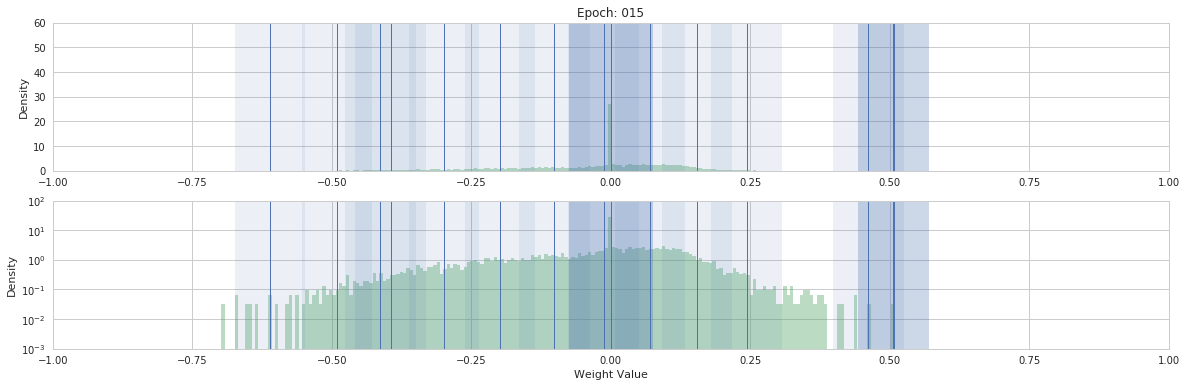

Epoch: 15. Loss: 0.00
Layer Loss: 5811.239
Layer Loss: -0.389
0-neglogprop Loss: -25501.625
Remaining-neglogprop Loss: -169471.375
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


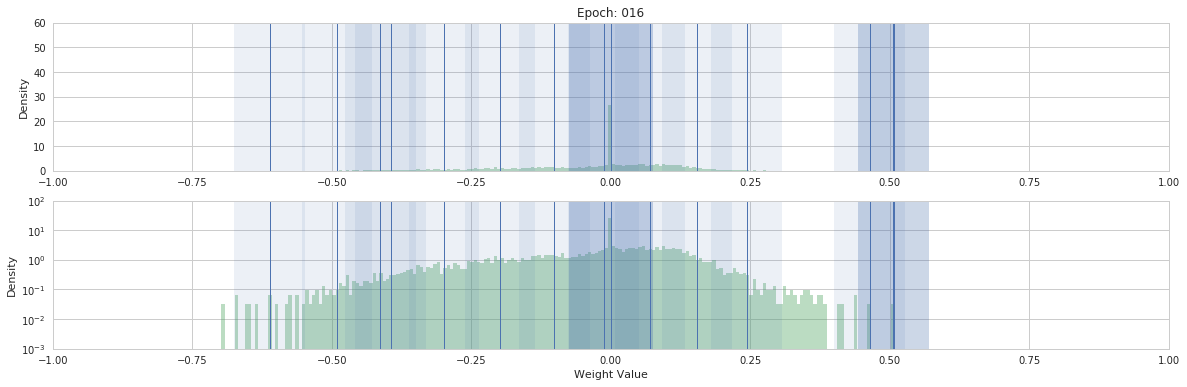

Epoch: 16. Loss: 0.00
Layer Loss: 5811.706
Layer Loss: -0.489
0-neglogprop Loss: -25502.201
Remaining-neglogprop Loss: -169471.375
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


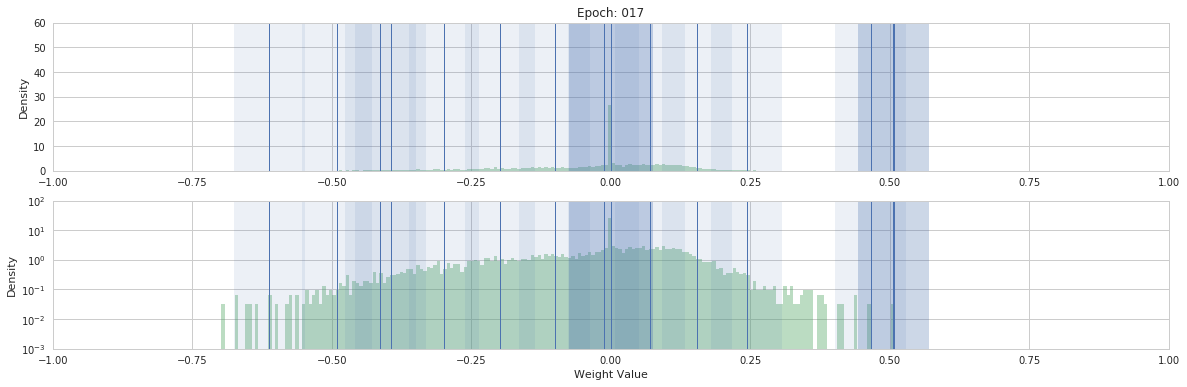

Epoch: 17. Loss: 0.00
Layer Loss: 5811.138
Layer Loss: -0.575
0-neglogprop Loss: -25501.828
Remaining-neglogprop Loss: -169471.375
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


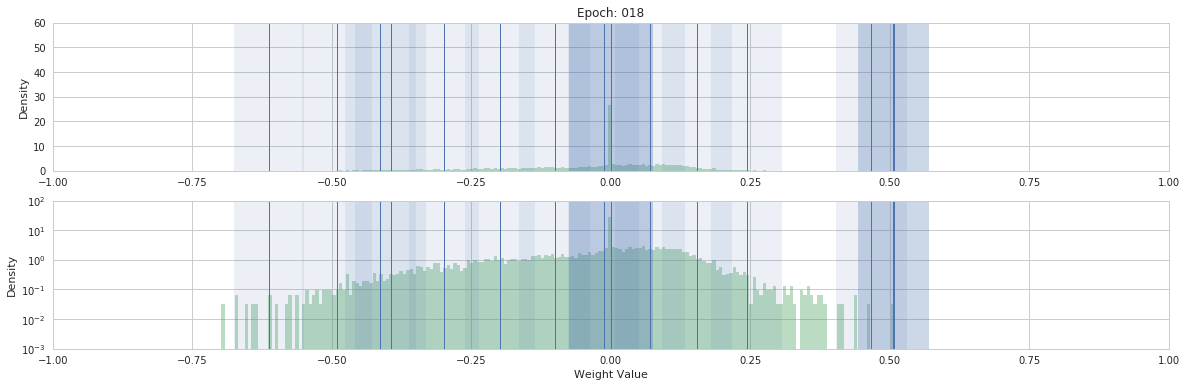

Epoch: 18. Loss: 0.00
Layer Loss: 5812.933
Layer Loss: -0.654
0-neglogprop Loss: -25502.670
Remaining-neglogprop Loss: -169471.375
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


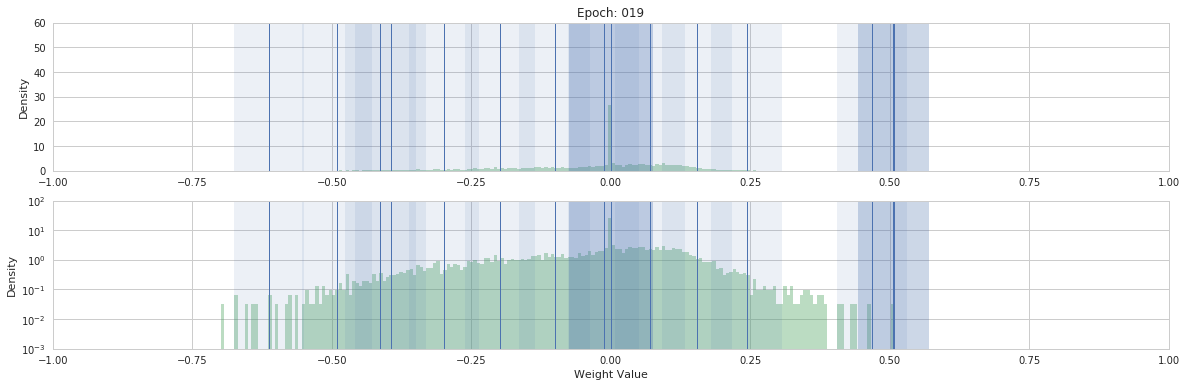

Epoch: 19. Loss: 0.00
Layer Loss: 5810.777
Layer Loss: -0.716
0-neglogprop Loss: -25500.988
Remaining-neglogprop Loss: -169471.375
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


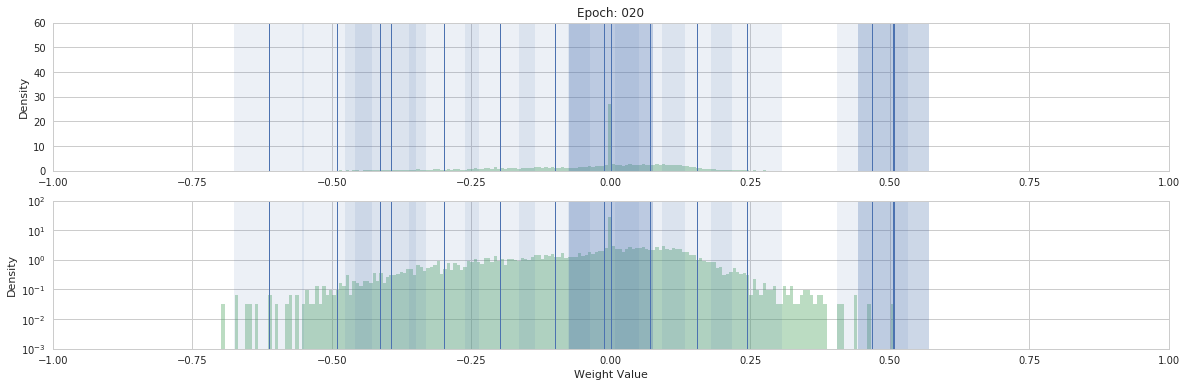

Epoch: 20. Loss: 0.00


(SWSModelFC2(
   (fc2): Linear(in_features=500, out_features=10, bias=True)
 ), GaussianMixturePrior(
 ))

In [67]:
def retrain_layer(model_retrain, model_orig, data_loader, test_data_full, test_labels_full):
    weight_loader = model_retrain.state_dict()
    for layer in model_retrain.state_dict():
        weight_loader[layer] = model_orig.state_dict()[layer]
    model_retrain.load_state_dict(weight_loader)

    #alpha, beta = (25000, 10)
    alpha, beta = (2500, 10)
    gmp = GaussianMixturePrior(16, [x for x in model_retrain.parameters()], 0.99, ab = (alpha, beta))

    sws_param1 = [gmp.means]
    sws_param2 = [gmp.gammas, gmp.rhos]

    print ("Model Name: {} Epochs: {}".format(model_retrain.name, training_epochs))
    print_dims(model_retrain)
    criterion = nn.MSELoss()
    optimizer_kd = torch.optim.Adam(model_retrain.parameters(), lr=1e-3, weight_decay = 0)
    optimizer_gmp1 = torch.optim.Adam(sws_param1, lr=1e-4)
    optimizer_gmp2 = torch.optim.Adam(sws_param2, lr=3e-3)
    
    for epoch in range(20):
        tau=5e-6
        model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer_kd, optimizer_gmp1, optimizer_gmp2, criterion, data_loader, tau)
        #if(writeTensorboard):
        #    for name, param in model_retrain.named_parameters():
        #       writer.add_histogram(graph_title + "/" + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')

        if (trueAfterN(epoch, 1)):
            gmp.print_batch = True
            get_layer_precision(model_fc, model, test_data_full, test_labels_full)
            show_sws_weights(model = model_retrain, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)
            print('Epoch: {}. Loss: {:.2f}'.format(epoch+1, float(loss.data)))
            
    return model_retrain, gmp

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 25.0
Model Name: SWSModelConv2 Epochs: 100
50x25x3x3 + 50
Layer Loss: 8048.500
Layer Loss: 24.987
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -101530.500
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


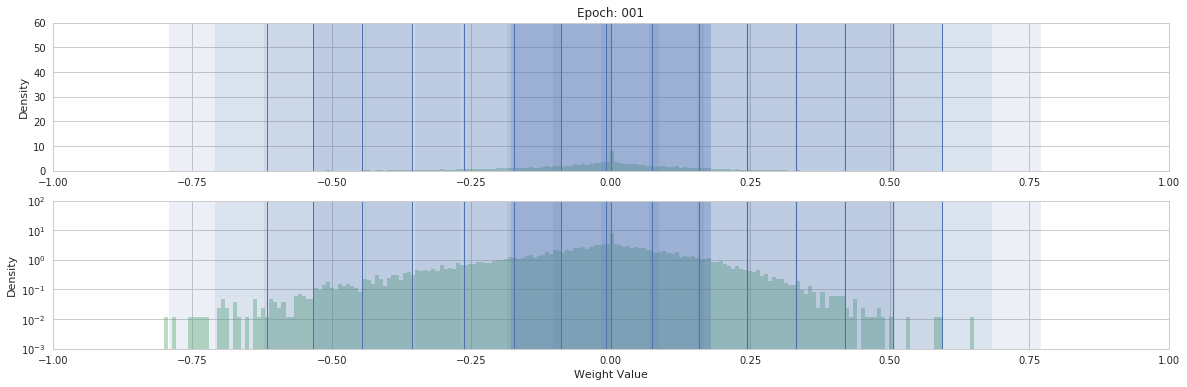

Epoch: 1. Loss: 0.00
Layer Loss: 6215.770
Layer Loss: 10.746
0-neglogprop Loss: -17127.822
Remaining-neglogprop Loss: -125180.602
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


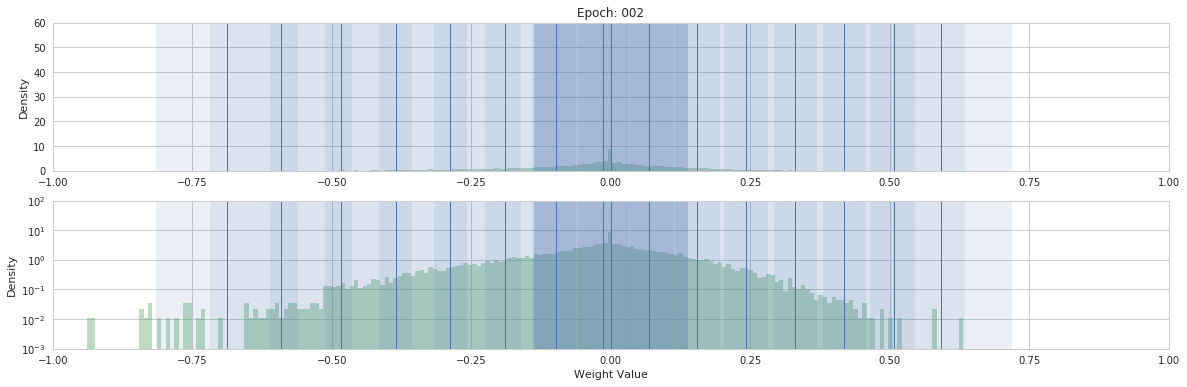

Epoch: 2. Loss: 0.00
Layer Loss: 5984.152
Layer Loss: 2.492
0-neglogprop Loss: -19677.922
Remaining-neglogprop Loss: -145309.922
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


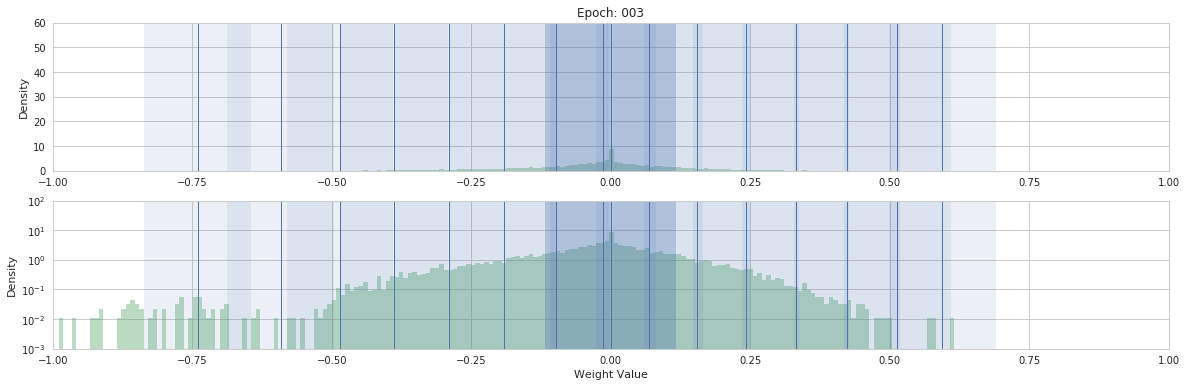

Epoch: 3. Loss: 0.00
Layer Loss: 6306.401
Layer Loss: -1.051
0-neglogprop Loss: -21283.531
Remaining-neglogprop Loss: -159644.469
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


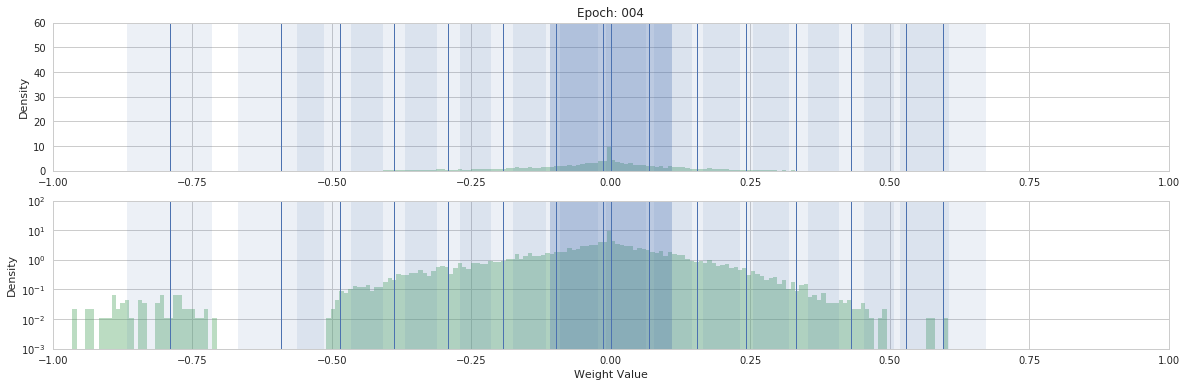

Epoch: 4. Loss: 0.00
Layer Loss: 6568.562
Layer Loss: -1.824
0-neglogprop Loss: -21969.594
Remaining-neglogprop Loss: -166946.688
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


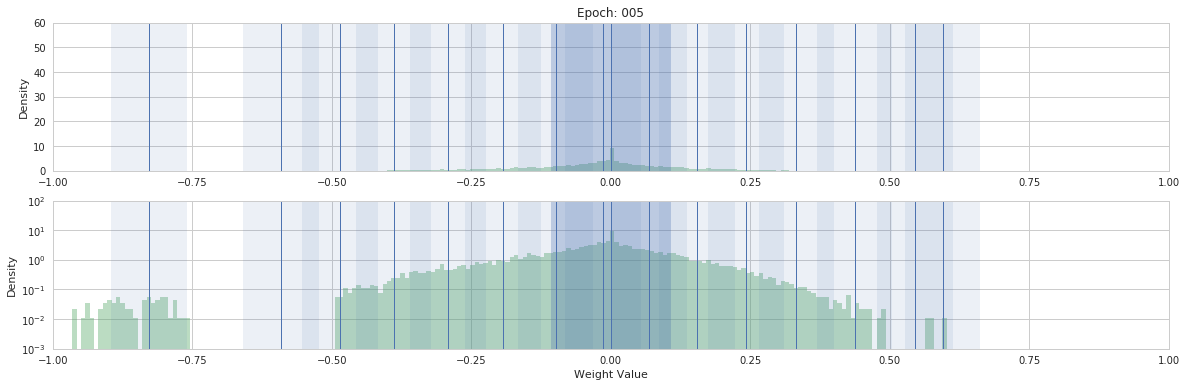

Epoch: 5. Loss: 0.01
Layer Loss: 6634.604
Layer Loss: -1.839
0-neglogprop Loss: -22147.389
Remaining-neglogprop Loss: -169120.344
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


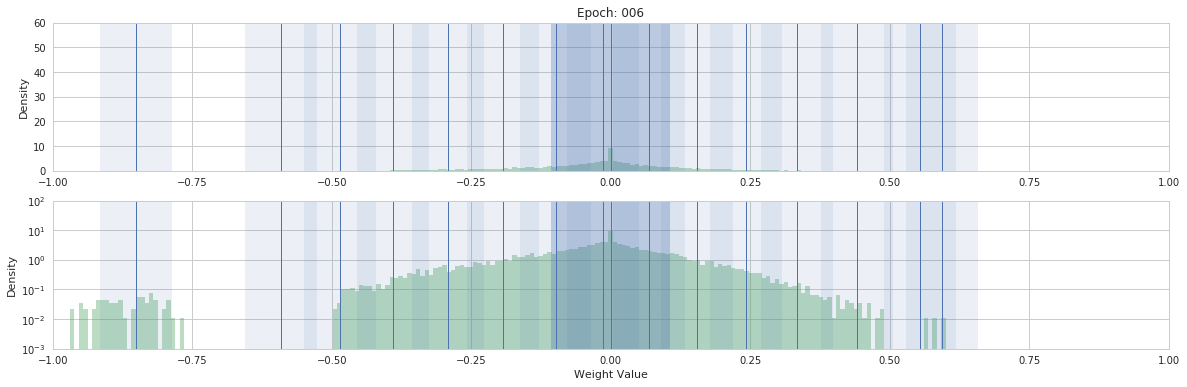

Epoch: 6. Loss: 0.01
Layer Loss: 6634.705
Layer Loss: -1.859
0-neglogprop Loss: -22186.023
Remaining-neglogprop Loss: -169446.562
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


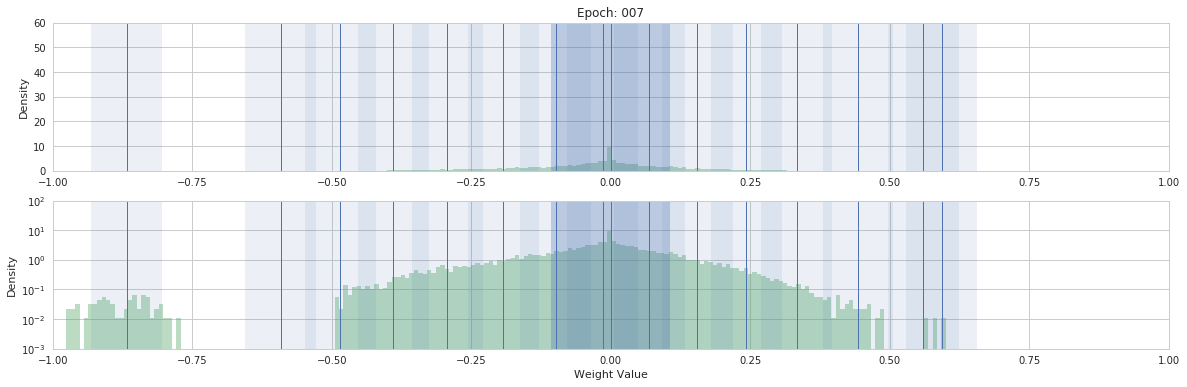

Epoch: 7. Loss: 0.01
Layer Loss: 6621.396
Layer Loss: -1.892
0-neglogprop Loss: -22199.234
Remaining-neglogprop Loss: -169471.000
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


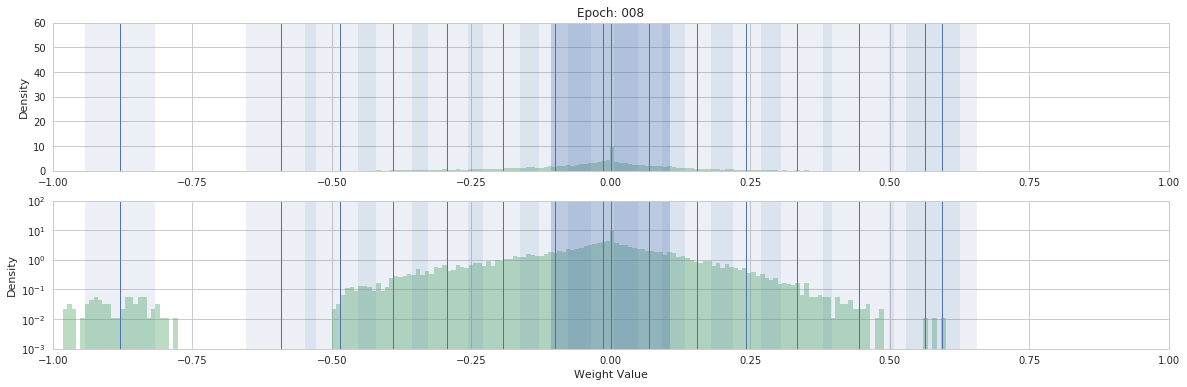

Epoch: 8. Loss: 0.01
Layer Loss: 6609.610
Layer Loss: -1.862
0-neglogprop Loss: -22206.906
Remaining-neglogprop Loss: -169471.938
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


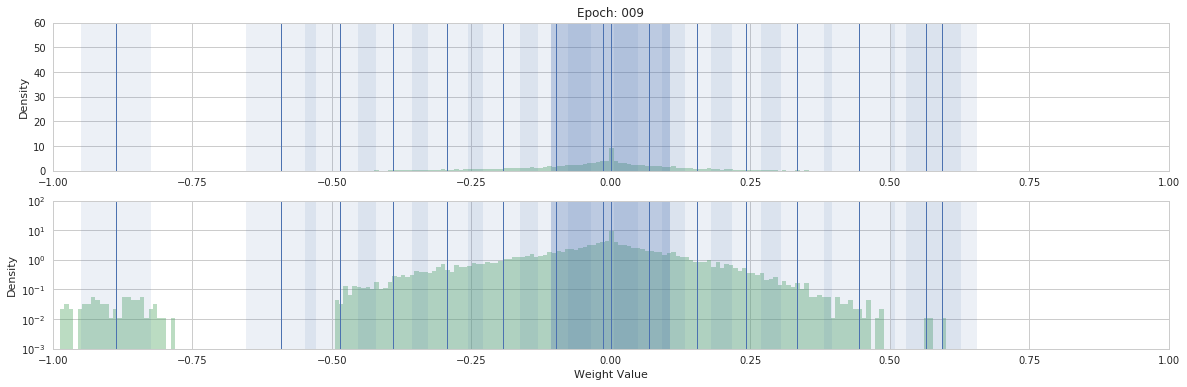

Epoch: 9. Loss: 0.01
Layer Loss: 6614.334
Layer Loss: -1.911
0-neglogprop Loss: -22211.541
Remaining-neglogprop Loss: -169471.938
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


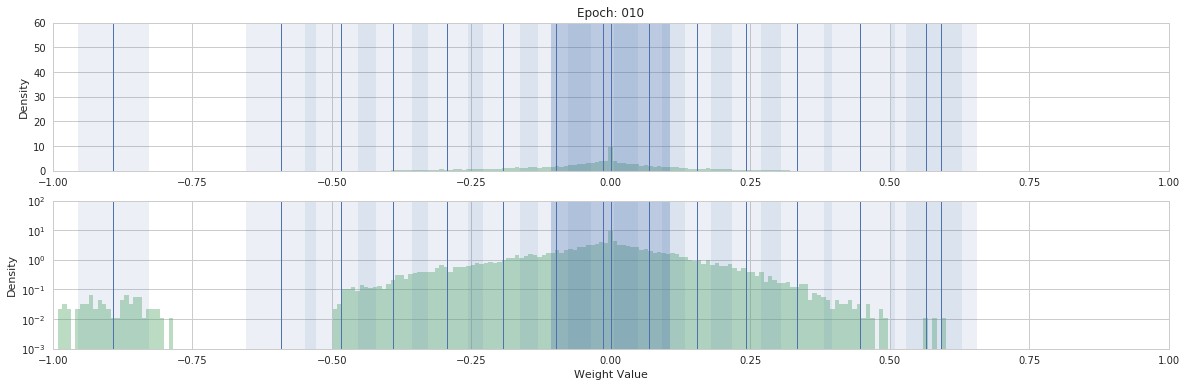

Epoch: 10. Loss: 0.01
Layer Loss: 6611.831
Layer Loss: -1.904
0-neglogprop Loss: -22216.066
Remaining-neglogprop Loss: -169471.938
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


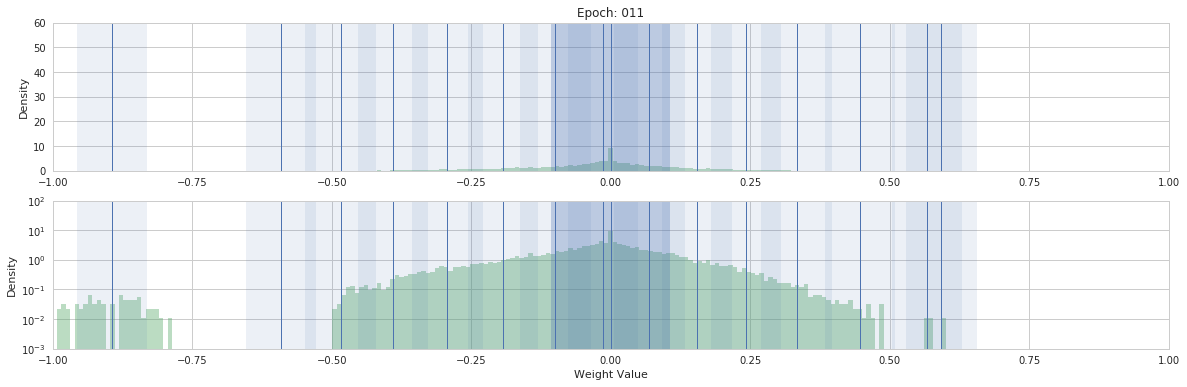

Epoch: 11. Loss: 0.01
Layer Loss: 6613.225
Layer Loss: -1.872
0-neglogprop Loss: -22218.986
Remaining-neglogprop Loss: -169471.938
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


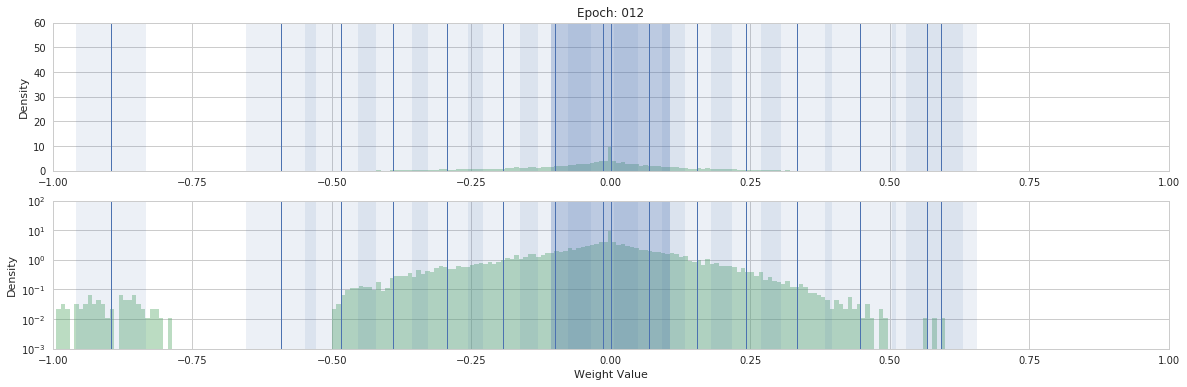

Epoch: 12. Loss: 0.01
Layer Loss: 6604.942
Layer Loss: -1.884
0-neglogprop Loss: -22218.414
Remaining-neglogprop Loss: -169471.938
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


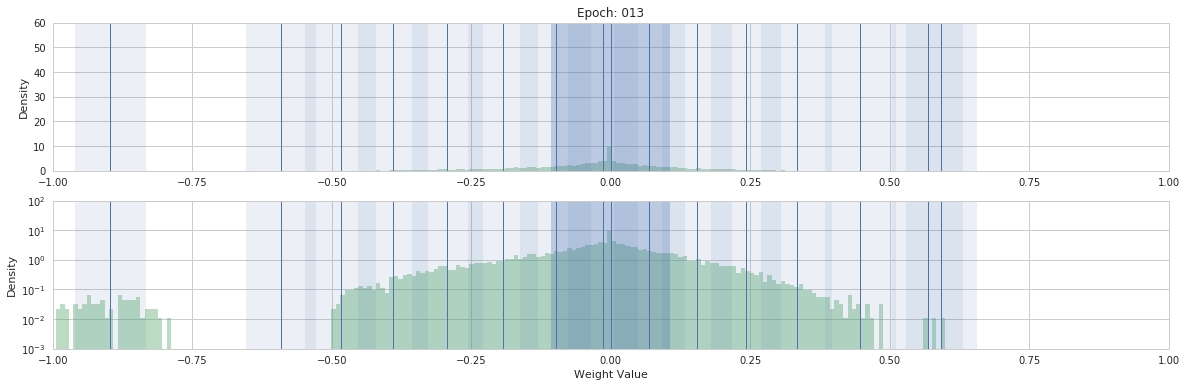

Epoch: 13. Loss: 0.01
Layer Loss: 6603.365
Layer Loss: -1.891
0-neglogprop Loss: -22219.643
Remaining-neglogprop Loss: -169471.938
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


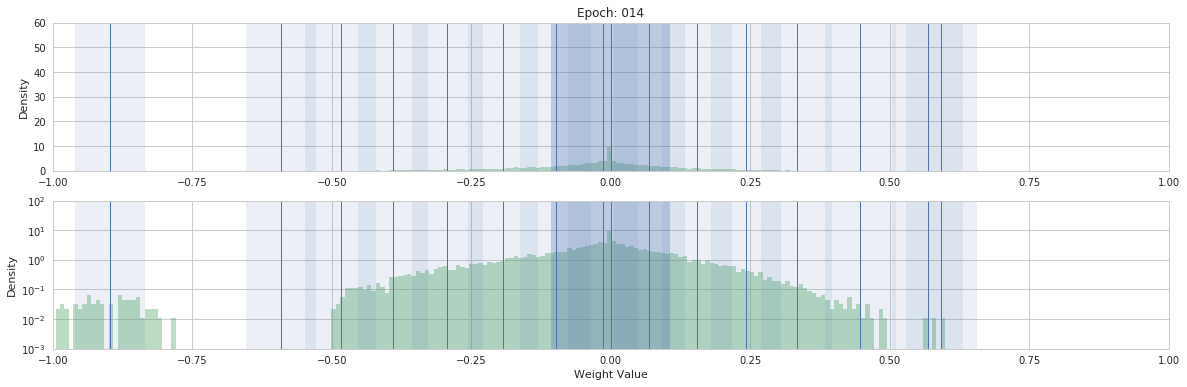

Epoch: 14. Loss: 0.01
Layer Loss: 6604.575
Layer Loss: -1.904
0-neglogprop Loss: -22218.508
Remaining-neglogprop Loss: -169471.938
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


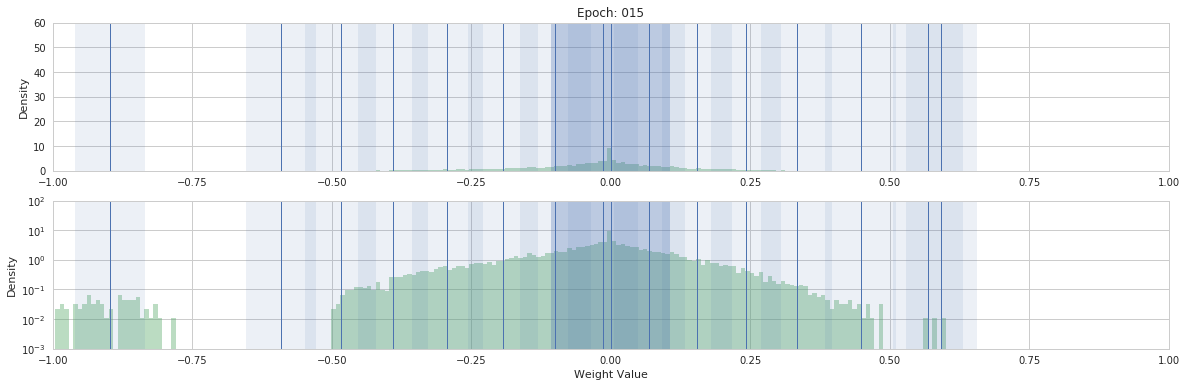

Epoch: 15. Loss: 0.01
Layer Loss: 6607.149
Layer Loss: -1.860
0-neglogprop Loss: -22219.410
Remaining-neglogprop Loss: -169471.938
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


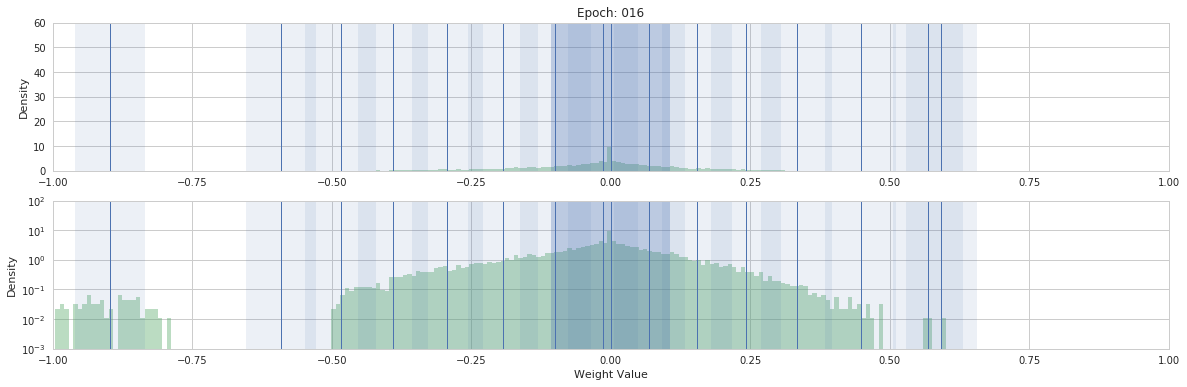

Epoch: 16. Loss: 0.01
Layer Loss: 6600.166
Layer Loss: -1.902
0-neglogprop Loss: -22217.980
Remaining-neglogprop Loss: -169471.938
Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


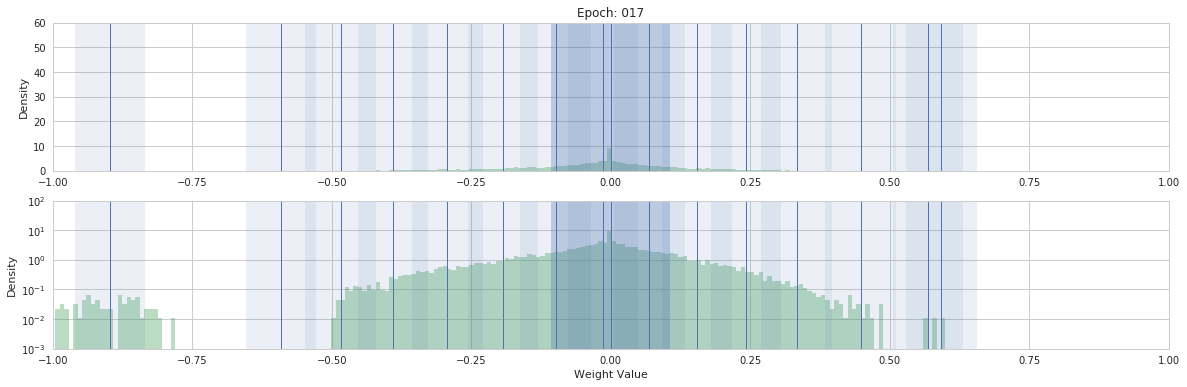

Epoch: 17. Loss: 0.01
Layer Loss: 6599.461
Layer Loss: -1.883
0-neglogprop Loss: -22221.033
Remaining-neglogprop Loss: -169471.938


In [ ]:
#conv1, conv1_gmp = retrain_layer(models.SWSModelConv1().cuda(), model, l1_loader, test_data_full, test_labels_full)
conv2, conv2_gmp = retrain_layer(models.SWSModelConv2().cuda(), model, l2_loader, test_data_full, test_labels_full)
fc1, fc1_gmp = retrain_layer(models.SWSModelFC1().cuda(), model, l3_loader, test_data_full, test_labels_full)
fc2, fc2_gmp = retrain_layer(models.SWSModelFC2().cuda(), model, l4_loader, test_data_full, test_labels_full)

In [43]:
#Init Model
'''
model_fc = models.SWSModelFC1().cuda()
weight_loader = model_fc.state_dict()
weight_loader['fc1.weight'] = model.state_dict()['fc1.weight']
weight_loader['fc1.bias'] = model.state_dict()['fc1.bias']
model_fc.load_state_dict(weight_loader)
'''
model_fc = models.SWSModelFC2().cuda()
weight_loader = model_fc.state_dict()
weight_loader['fc2.weight'] = model.state_dict()['fc2.weight']
weight_loader['fc2.bias'] = model.state_dict()['fc2.bias']
model_fc.load_state_dict(weight_loader)


#alpha, beta = (25000, 10)
alpha, beta = (2500, 10)
gmp = GaussianMixturePrior(16, [x for x in model_fc.parameters()], 0.99, ab = (alpha, beta))

sws_param1 = [gmp.means]
sws_param2 = [gmp.gammas, gmp.rhos]

print ("Model Name: {} Epochs: {}".format(model.name, training_epochs))
print_dims(model_fc)
criterion = nn.MSELoss()
optimizer_kd = torch.optim.Adam(model_fc.parameters(), lr=1e-3, weight_decay = 0)
optimizer_gmp1 = torch.optim.Adam(sws_param1, lr=1e-4)
optimizer_gmp2 = torch.optim.Adam(sws_param2, lr=3e-3)

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 25.0
Model Name: SWSModel Epochs: 100
10x500 + 10


Layer Loss: 3687.514
Layer Loss: -12.204
0-neglogprop Loss: -29784.193
Remaining-neglogprop Loss: -169471.922


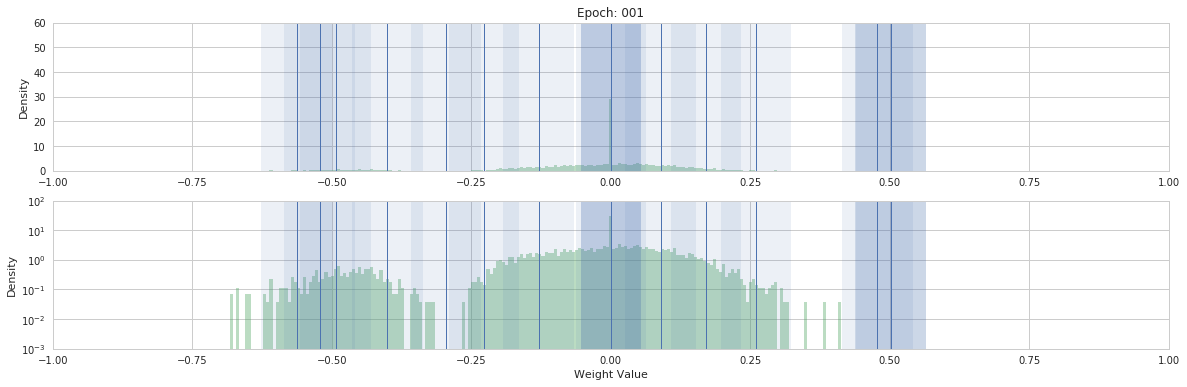

Epoch: 1. Loss: 3.99
Layer Loss: 6319.570
Layer Loss: -10.515
0-neglogprop Loss: -28596.662
Remaining-neglogprop Loss: -169470.953


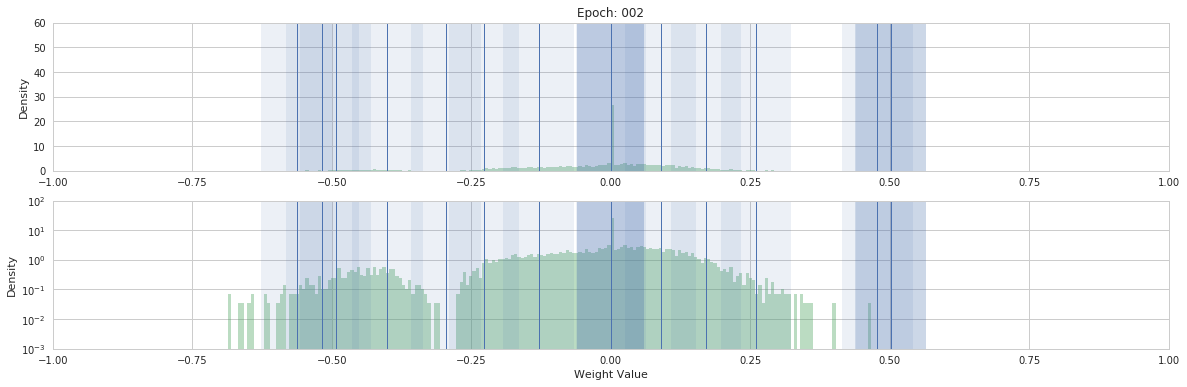

Epoch: 2. Loss: 2.02
Layer Loss: 6299.166
Layer Loss: -9.168
0-neglogprop Loss: -27529.445
Remaining-neglogprop Loss: -169466.719


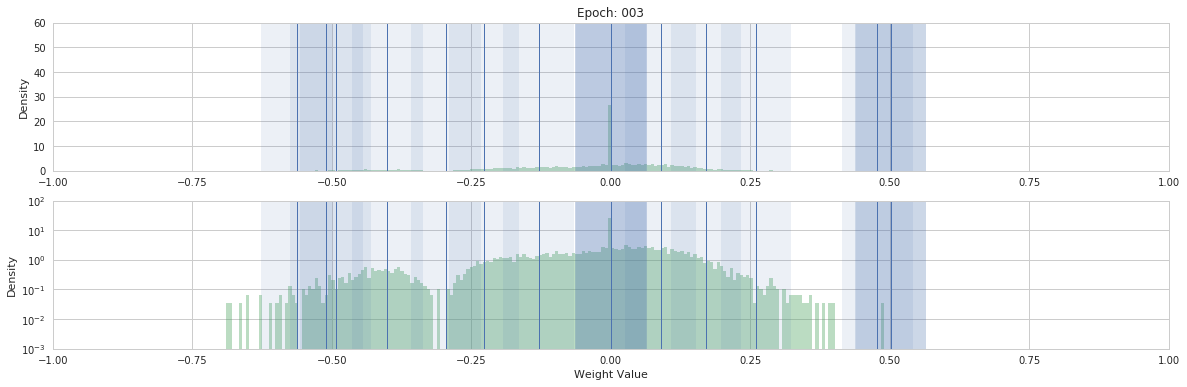

Epoch: 3. Loss: 1.00
Layer Loss: 6283.348
Layer Loss: -8.403
0-neglogprop Loss: -26901.193
Remaining-neglogprop Loss: -169463.359


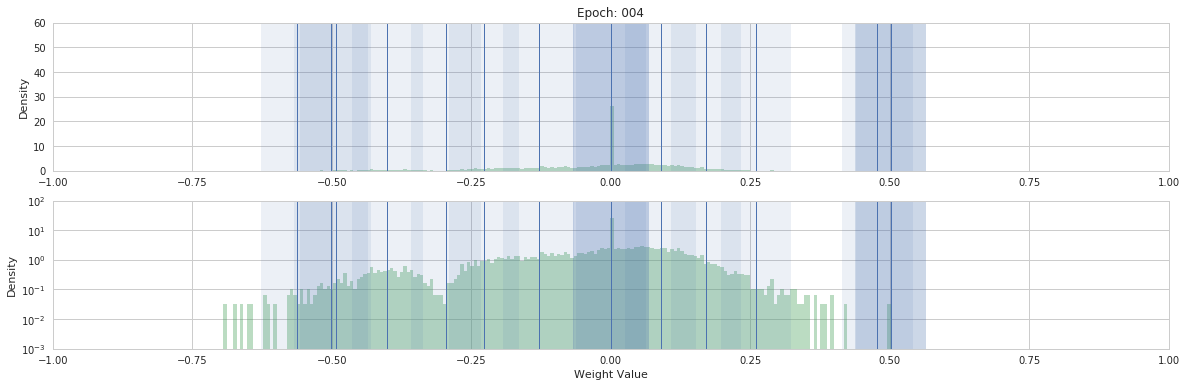

Epoch: 4. Loss: 0.54
Layer Loss: 6231.678
Layer Loss: -7.895
0-neglogprop Loss: -26474.309
Remaining-neglogprop Loss: -169463.391


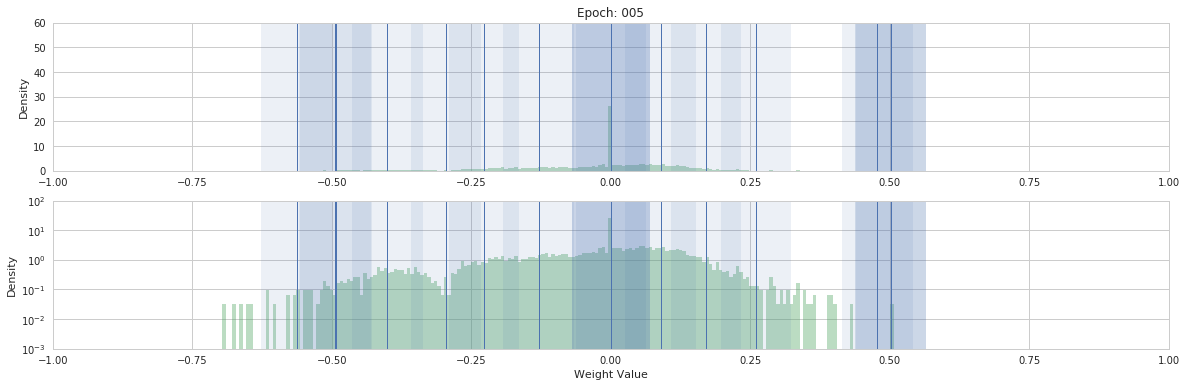

Epoch: 5. Loss: 0.27
Layer Loss: 6114.458
Layer Loss: -7.494
0-neglogprop Loss: -26128.678
Remaining-neglogprop Loss: -169465.719


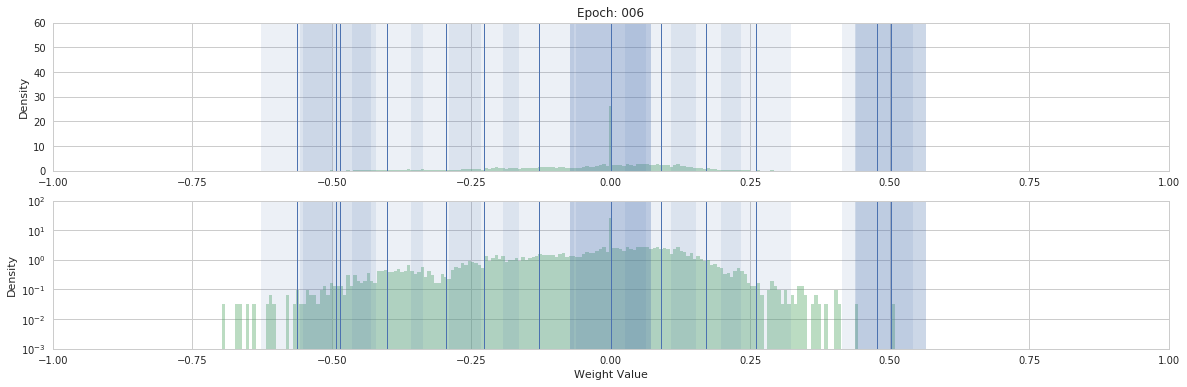

Epoch: 6. Loss: 0.13
Layer Loss: 5962.572
Layer Loss: -7.169
0-neglogprop Loss: -25840.918
Remaining-neglogprop Loss: -169468.125


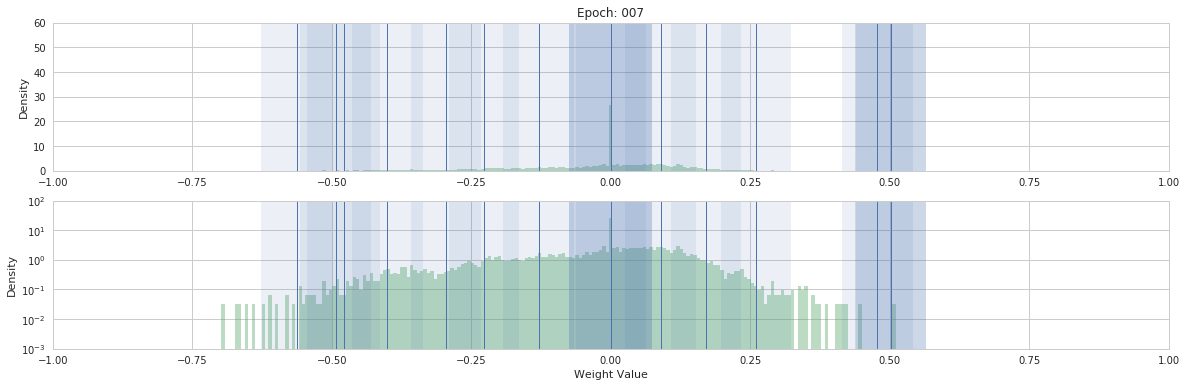

Epoch: 7. Loss: 0.08
Layer Loss: 5833.062
Layer Loss: -6.928
0-neglogprop Loss: -25626.986
Remaining-neglogprop Loss: -169469.609


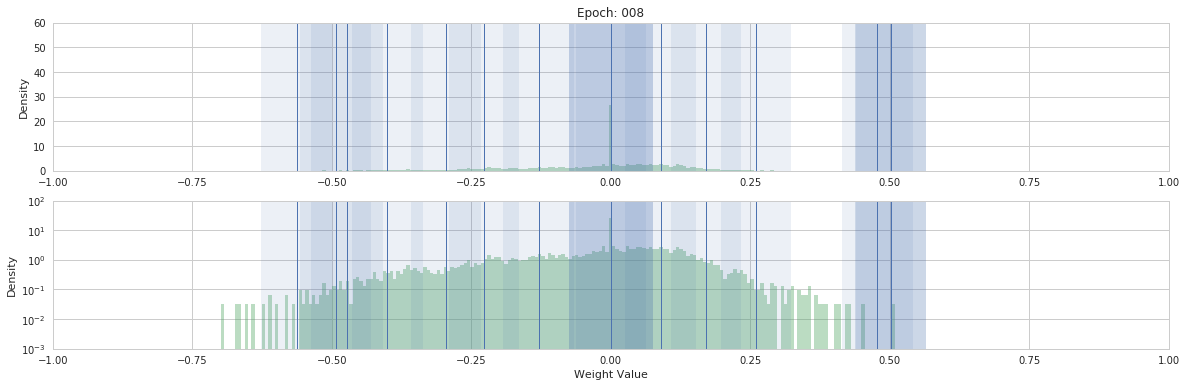

Epoch: 8. Loss: 0.05
Layer Loss: 5738.358
Layer Loss: -6.761
0-neglogprop Loss: -25481.238
Remaining-neglogprop Loss: -169470.438


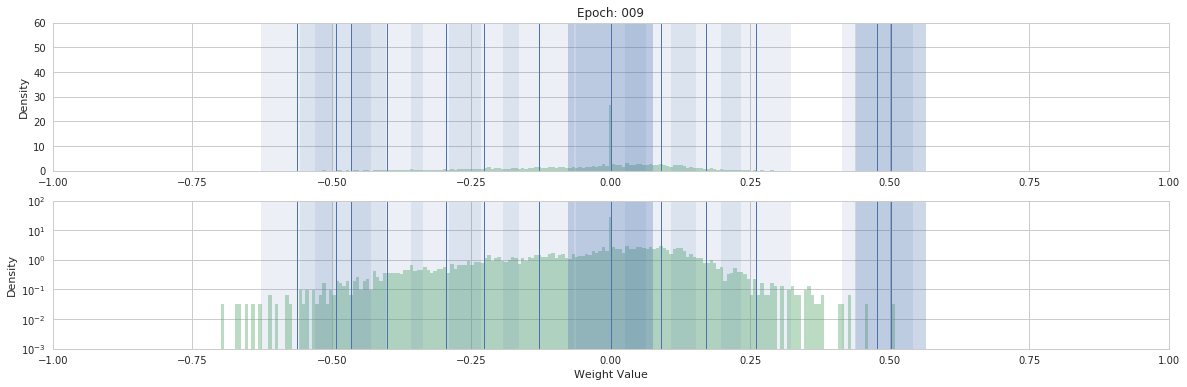

Epoch: 9. Loss: 0.02
Layer Loss: 5678.455
Layer Loss: -6.651
0-neglogprop Loss: -25390.100
Remaining-neglogprop Loss: -169470.891


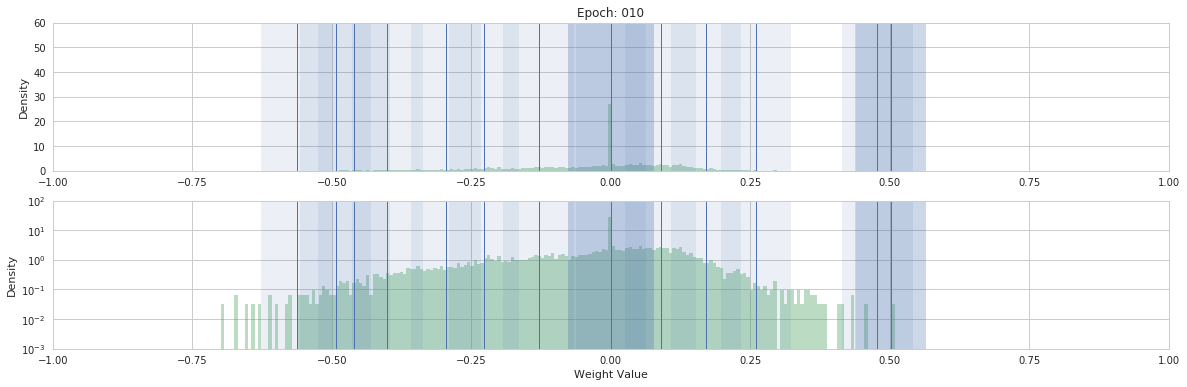

Epoch: 10. Loss: 0.01
Layer Loss: 5645.004
Layer Loss: -6.580
0-neglogprop Loss: -25339.031
Remaining-neglogprop Loss: -169471.141


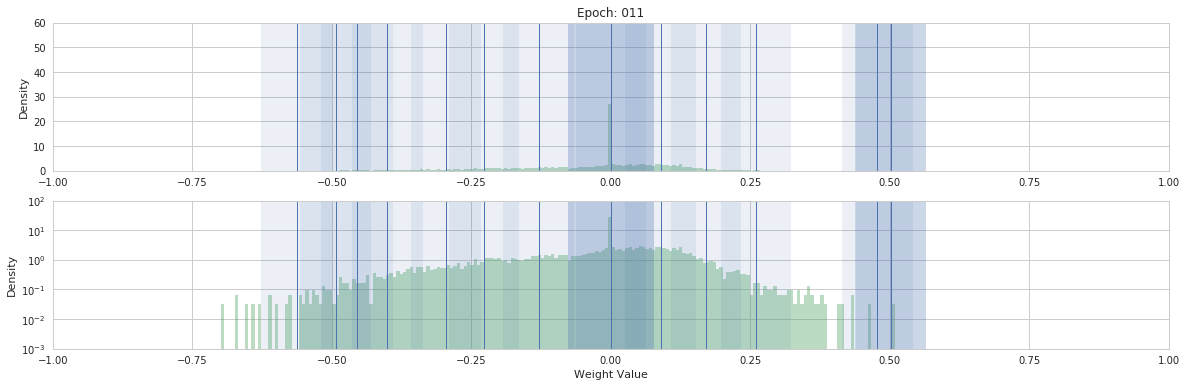

Epoch: 11. Loss: 0.01
Layer Loss: 5632.471
Layer Loss: -6.534
0-neglogprop Loss: -25317.670
Remaining-neglogprop Loss: -169471.281


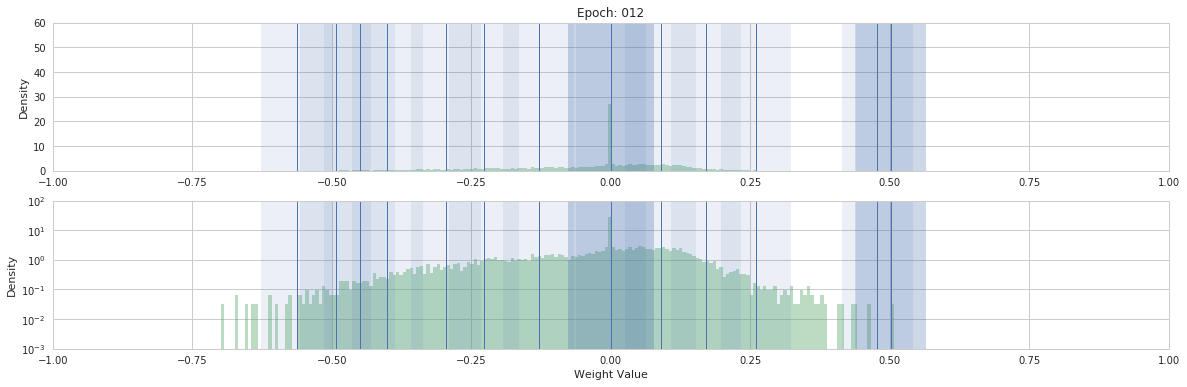

Epoch: 12. Loss: 0.00
Layer Loss: 5635.138
Layer Loss: -6.497
0-neglogprop Loss: -25316.102
Remaining-neglogprop Loss: -169471.375


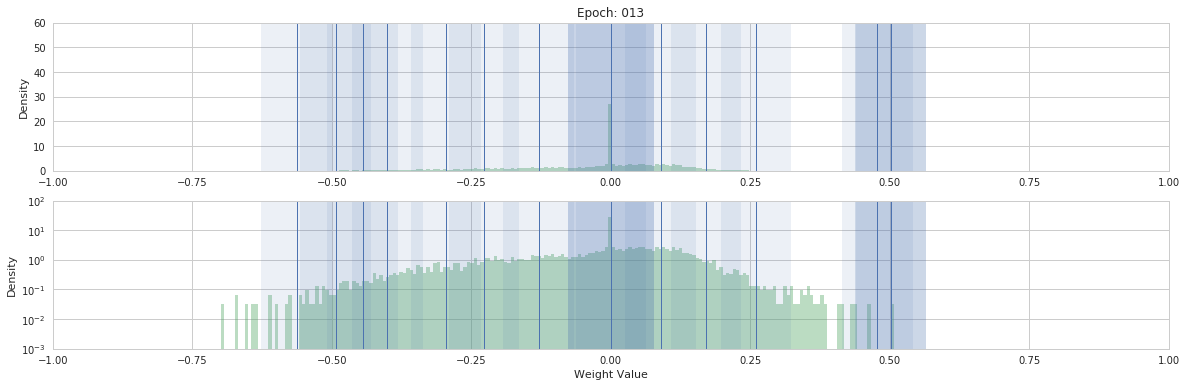

Epoch: 13. Loss: 0.00
Layer Loss: 5645.898
Layer Loss: -6.459
0-neglogprop Loss: -25326.514
Remaining-neglogprop Loss: -169471.422


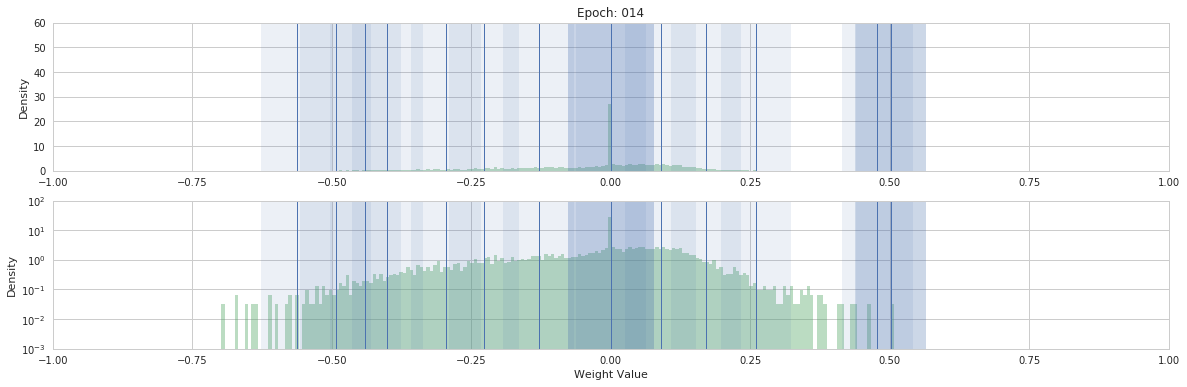

Epoch: 14. Loss: 0.00
Layer Loss: 5663.064
Layer Loss: -6.412
0-neglogprop Loss: -25344.910
Remaining-neglogprop Loss: -169471.453


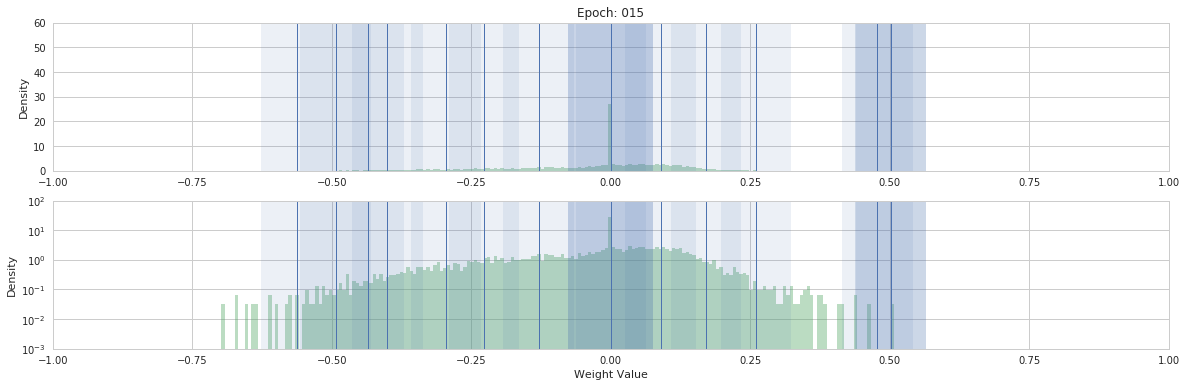

Epoch: 15. Loss: 0.00
Layer Loss: 5683.932
Layer Loss: -6.346
0-neglogprop Loss: -25367.611
Remaining-neglogprop Loss: -169471.469


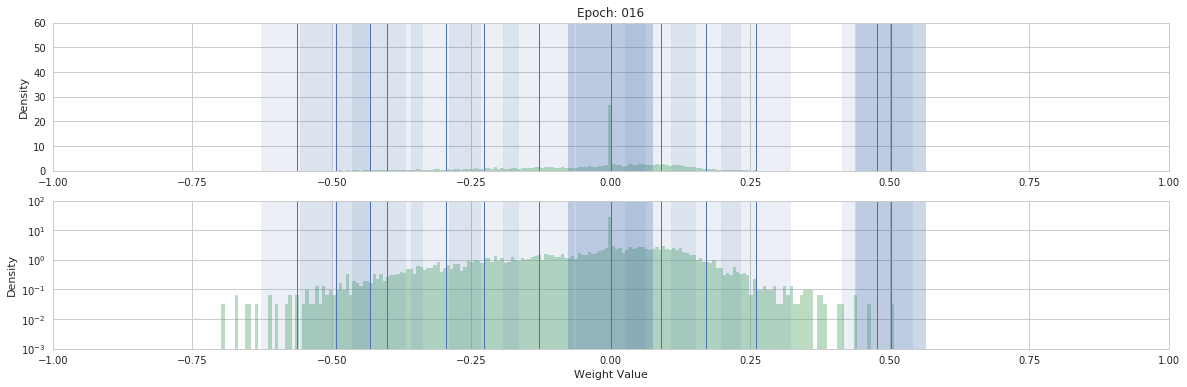

Epoch: 16. Loss: 0.00
Layer Loss: 5706.167
Layer Loss: -6.255
0-neglogprop Loss: -25391.893
Remaining-neglogprop Loss: -169471.469


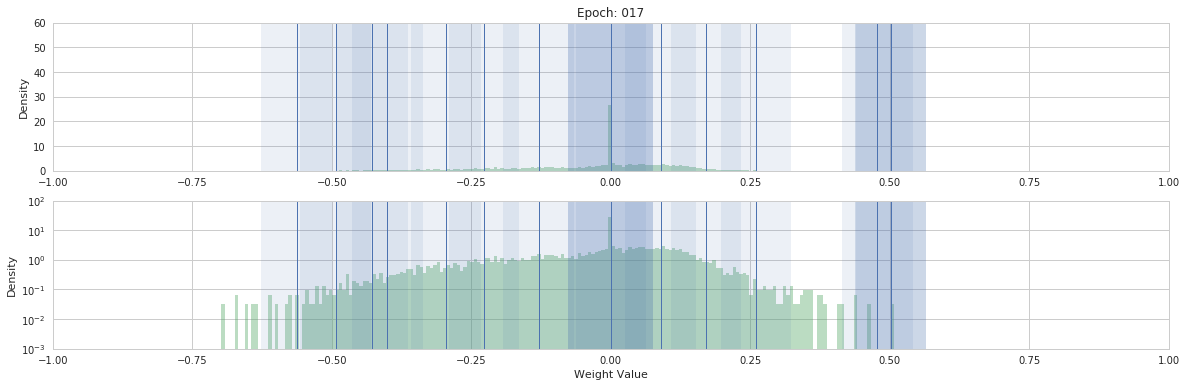

Epoch: 17. Loss: 0.00
Layer Loss: 5728.176
Layer Loss: -6.132
0-neglogprop Loss: -25415.561
Remaining-neglogprop Loss: -169471.453


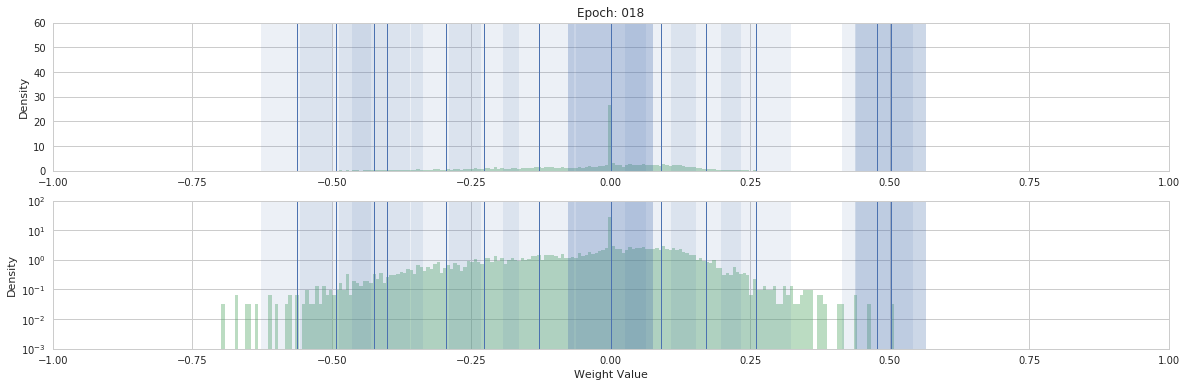

Epoch: 18. Loss: 0.00
Layer Loss: 5748.604
Layer Loss: -5.973
0-neglogprop Loss: -25437.258
Remaining-neglogprop Loss: -169471.453


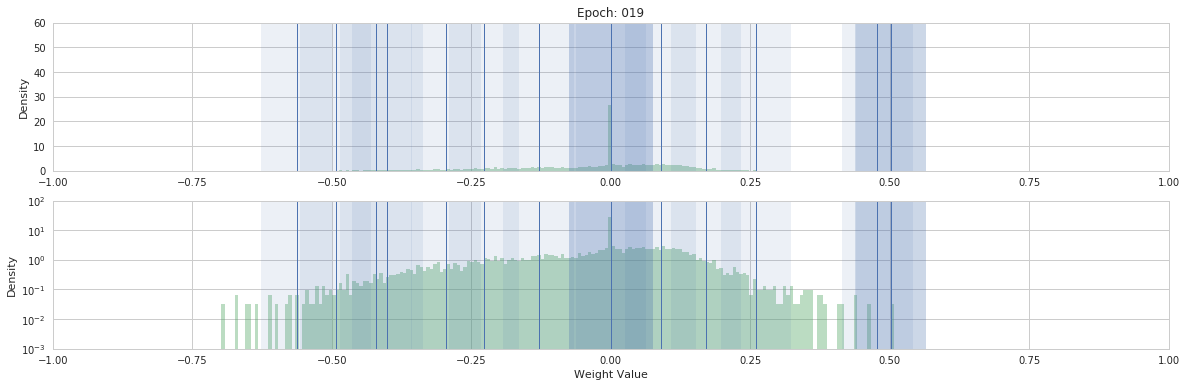

Epoch: 19. Loss: 0.00
Layer Loss: 5766.464
Layer Loss: -5.776
0-neglogprop Loss: -25456.102
Remaining-neglogprop Loss: -169471.438


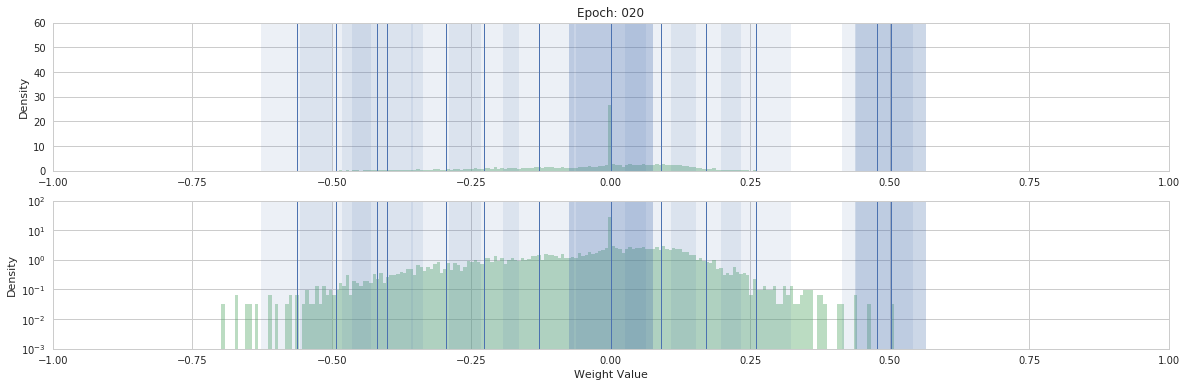

Epoch: 20. Loss: 0.00


In [57]:
graph_title = "fc2_retrain_gmp"

for epoch in range(20):
    tau=5e-6
    model_fc, loss = retrain_sws_epoch(model_fc, gmp, optimizer_kd, optimizer_gmp1, optimizer_gmp2, criterion, l4_loader, tau)
    if(writeTensorboard):
        for name, param in model_fc.named_parameters():
            writer.add_histogram(graph_title + "/" + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')

    if (trueAfterN(epoch, 1)):
        gmp.print_batch = True
        show_sws_weights(model = model_fc, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)
        print('Epoch: {}. Loss: {:.2f}'.format(epoch+1, float(loss.data)))

In [66]:
def get_layer_precision(model_retrain, model_orig, data, labels):
    model_acc = copy.deepcopy(model_orig)
    org_acc = (test_accuracy(data, labels, model))

    weight_loader = copy.deepcopy(model_orig.state_dict())
    for layer in model_fc.state_dict():
        weight_loader[layer] = model_retrain.state_dict()[layer]
    model_acc.load_state_dict(weight_loader)
    retrain_acc = (test_accuracy(data, labels, model_acc))
    model_acc.load_state_dict(model_orig.state_dict())

    model_prune = copy.deepcopy(model_retrain)
    model_prune.load_state_dict(sws_prune(model_prune, gmp))

    weight_loader = copy.deepcopy(model_orig.state_dict())
    for layer in model_prune.state_dict():
        weight_loader[layer] = model_prune.state_dict()[layer]
    model_acc.load_state_dict(weight_loader)
    prune_acc = (test_accuracy(data, labels, model_acc))
    model_acc.load_state_dict(model_orig.state_dict())
    
    print ("Original: {:.2f}% - Retrain: {:.2f}% - Prune: {:.2f}%".format(org_acc[0], retrain_acc[0], prune_acc[0]))
    
get_layer_precision(model_fc, model, test_data_full, test_labels_full)

Original: 98.89% - Retrain: 98.89% - Prune: 98.71%


In [62]:
print (test_accuracy(test_data_full, test_labels_full, model))

weight_loader = copy.deepcopy(model.state_dict())
weight_loader['fc2.weight'] = model_fc.state_dict()['fc2.weight']
weight_loader['fc2.bias'] = model_fc.state_dict()['fc2.bias']
model_acc.load_state_dict(weight_loader)
print (test_accuracy(test_data_full, test_labels_full, model_acc))
model_acc.load_state_dict(model.state_dict())

model_prune = copy.deepcopy(model_fc)
model_prune.load_state_dict(sws_prune(model_prune, gmp))

weight_loader = copy.deepcopy(model.state_dict())
weight_loader['fc2.weight'] = model_prune.state_dict()['fc2.weight']
weight_loader['fc2.bias'] = model_prune.state_dict()['fc2.bias']
model_acc.load_state_dict(weight_loader)
print (test_accuracy(test_data_full, test_labels_full, model_acc))
model_acc.load_state_dict(model.state_dict())

(98.89, 1.4722000360488892)
(98.89, 1.472198724746704)
(98.71, 1.4737735986709595)


In [20]:
weight_loader = copy.deepcopy(model.state_dict())
print (test_accuracy(test_data_full, test_labels_full, model))
weight_loader['fc1.weight'] = model_fc.state_dict()['fc1.weight']
weight_loader['fc1.bias'] = model_fc.state_dict()['fc1.bias']
model.load_state_dict(weight_loader)
print (test_accuracy(test_data_full, test_labels_full, model))

(98.89, 1.4722000360488892)
(98.88, 1.472216248512268)


### 3. Prune Model

In [37]:
print (test_accuracy(test_data_full, test_labels_full, model))
print (test_accuracy(test_data_full, test_labels_full, model_retrain))

(98.91, 1.4718830585479736)


(98.58, 1.4843623638153076)


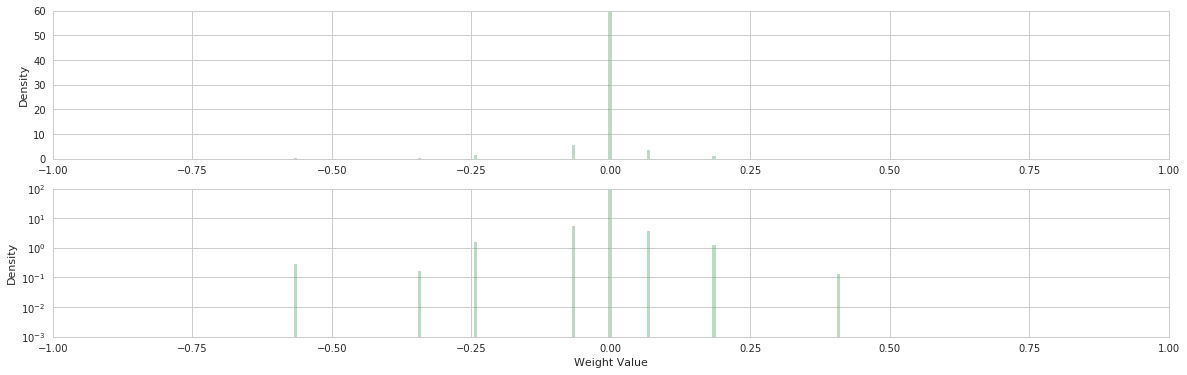

In [32]:
model_prune = copy.deepcopy(model_retrain)
model_prune.load_state_dict(sws_prune(model_prune, gmp))
print (test_accuracy(test_data_full, test_labels_full, model_prune))
show_sws_weights(model_prune)

In [36]:
(special_flatten(model_prune.state_dict())==0).sum()/642460.0

0.9256576284904897